In [1]:
import numpy as np
rd = np.random
import matplotlib.pyplot as pl

from scipy.stats import iqr

import timeit

# Differential Entropy

## 1 dimension

In [2]:
def diff_entropy(data):
    '''Computes differential entropy from one dimensional data array'''
    
    #bin width estimated from Freedman-Diaconis rule
    dx = 2*iqr(data)/(len(data)**(1/3))
    counts,bins=np.histogram(data,bins=int(np.round((max(data)-min(data))/dx)))
    dx = bins[1]-bins[0] #redefine bin width
    
    pdf = counts/np.sum(counts*dx)
    return -np.sum(pdf[pdf!=0]*np.log(pdf[pdf!=0]))*dx

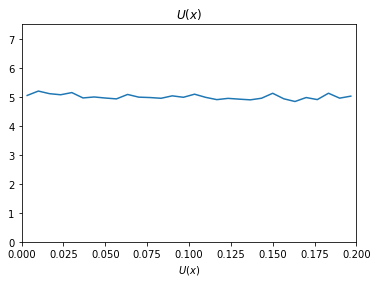

Entropy:
Numerical: -1.6097548432168662
Theoretical: -1.6094379124341003
Error: 0.00019692016716981196


In [13]:
#number of events
n=100000

#parameters of the uniform distribution
x1=0
x2=0.2

U = rd.random(n)*(x2-x1)+x1

#Plot a histogram
counts,bins=np.histogram(U,bins=30)
dx = bins[1]-bins[0]
pl.plot(bins[:-1]+dx/2,counts/(np.sum(counts*dx)))
pl.xlim(x1,x2)
pl.ylim(0, 1/x2 * 1.5)
pl.xlabel("$x$")
pl.xlabel("$U(x)$")
pl.title("$U(x)$")
pl.show()

#Compute the entropy
print('Entropy:')
print('Numerical:',diff_entropy(U))
print('Theoretical:',np.log(x2-x1))

print('Error:',(diff_entropy(U)-np.log(x2-x1))/np.log(x2-x1))
del U

## d dimensions

In [4]:
def diff_entropydd(data):
    '''Computes differential entropy from d-dimensional data array, with d greater than 1'''
    
    #bin widths estimated from Freedman-Diaconis rule  
    dx = 2*iqr(data,axis=1)/(len(data[0])**(1/3))
    counts,bins=np.histogramdd(data.T, bins=np.round((np.max(data,axis=1)-np.min(data,axis=1))/dx).astype(int))
    dx = np.array([bins[i][1]-bins[i][0] for i in range(len(dx))])  #redefine bin widths
    
    pdf = counts/np.sum(counts*np.prod(dx))
    return -np.sum(pdf[pdf!=0]*np.log(pdf[pdf!=0]))*np.prod(dx)

### 2d

In [12]:
#number of events
n=1000000

#parameters of the uniform distributions
x1=0
x2=10
y1=0
y2=10

U = (rd.random([n,2])*(np.array([x2,y2])-np.array([x1,y1])) + np.array([x1,y1])).T

#Compute the entropy
print('Entropy:')
print('Numerical:',diff_entropydd(U))
print('Theoretical:',np.log((x2-x1)*(y2-y1)))

print('Error:',(diff_entropydd(U)-np.log((x2-x1)*(y2-y1)))/np.log((x2-x1)*(y2-y1)))
del U

Entropy:
Numerical: 4.600185532895303
Theoretical: 4.605170185988092
Error: -0.0010824036662001333


### 3d

In [11]:
#number of events
n=1000000

#parameters of the uniform distributions
x1=0
x2=200
y1=0
y2=20
z1=0
z2=2

U = (rd.random([n,3])*(np.array([x2,y2,z2])-np.array([x1,y1,z1])) + np.array([x1,y1,z1])).T

print('Entropy:')
print('Numerical:',diff_entropydd(U))
print('Theoretical:',np.log((x2-x1)*(y2-y1)*(z2-z1)))

print('Error:',(diff_entropydd(U)-np.log((x2-x1)*(y2-y1)*(z2-z1)))/np.log((x2-x1)*(y2-y1)*(z2-z1)))
del U

Entropy:
Numerical: 8.413662943618407
Theoretical: 8.987196820661973
Error: -0.06381677051124392


## Tests with normal distributions

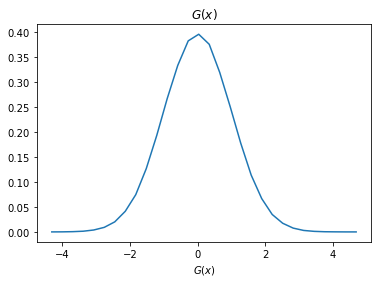

Entropy:
Numerical: 1.4185004852501106
Theoretical: 1.4189385332046727
Error: -0.0004380479545620375


In [10]:
#number of events
n=1000000

miu = 0
sigma = 1/np.sqrt(2*np.pi*np.e)
sigma = 1
U = rd.normal(loc=miu, scale=sigma, size=n)

counts,bins=np.histogram(U,bins=30)
dx = bins[1]-bins[0]
pl.plot(bins[:-1]+dx/2,counts/(np.sum(counts*dx)))
pl.xlabel("$x$")
pl.xlabel("$G(x)$")
pl.title("$G(x)$")
pl.show()

print('Entropy:')
print('Numerical:',diff_entropy(U))
theoretical = np.log(2*np.pi*sigma*sigma)/2 + 1/2
print('Theoretical:',theoretical)

print('Error:',(diff_entropy(U)-theoretical))
del U

In [9]:
#number of events
n=1000000

miu = 0
sigma = 1
U = rd.normal(loc=miu, scale=sigma, size=(2,n))

print('Entropy:')
print('Numerical:',diff_entropydd(U))
theoretical = np.log(2*np.pi*sigma*sigma) + 1
print('Theoretical:',theoretical)

print('Error:',(diff_entropydd(U)-theoretical))
del U

Entropy:
Numerical: 2.806245151845085
Theoretical: 2.8378770664093453
Error: -0.03163191456426029


# Mutual Information

In [16]:
def MI(A,B):
    '''Computes the differential mutual information between two 1-dimensional data arrays, A and B. - I(A,B).'''
    
    #bin widths estimated from Freedman-Diaconis rule  
    dA = 2*iqr(A)/(len(A)**(1/3))
    dB = 2*iqr(B)/(len(B)**(1/3))
    
    if dA==0 or dB==0: #integral of 0 size
        return 0.

    countA,binA=np.histogram(A, bins=np.round((np.max(A)-np.min(A))/dA).astype(int))
    dA = binA[1] - binA[0] #redefine bin widths
    pA = countA/np.sum(countA*dA)
    
    countB,binB=np.histogram(B, bins=np.round((np.max(B)-np.min(B))/dB).astype(int))
    dB = binB[1] - binB[0] #redefine bin widths
    pB = countB/np.sum(countB*dB)
    
    countAB=np.histogramdd([A,B], bins=[binA,binB])[0]
    pAB = countAB/np.sum(countAB*dA*dB)
    
    nonzero = pAB!=0
    return np.sum(pAB[nonzero]*np.log(pAB[nonzero]/np.tensordot(pA,pB,axes=0)[nonzero]))*dA*dB

In [20]:
def MI2(A,B):
    '''Computes the differential mutual information between two 1-dimensional data arrays, A and B. - I(A,B).
    Requires less memory for sparse distributions, but takes longer.'''
    
    #bin widths estimated from Freedman-Diaconis rule  
    dA = 2*iqr(A)/(len(A)**(1/3))
    dB = 2*iqr(B)/(len(B)**(1/3))
    
    if dA==0 or dB==0: #integral of 0 size
        return 0.

    countA,binA=np.histogram(A, bins=np.round((np.max(A)-np.min(A))/dA).astype(int))
    posA, countA = np.where(countA!=0)[0], countA[countA!=0]
    pA = countA/np.sum(countA*dA)
    dA = binA[1] - binA[0] #redefine bin widths
    
    countB,binB=np.histogram(B, bins=np.round((np.max(B)-np.min(B))/dB).astype(int))
    posB, countB = np.where(countB!=0)[0], countB[countB!=0]
    pB = countB/np.sum(countB*dB)
    dB = binB[1] - binB[0] #redefine bin widths

    countAB=np.histogramdd([A,B], bins=[binA,binB])[0]
    posAB, countAB = np.array(np.where(countAB!=0)).T, countAB[countAB!=0]
    pAB = countAB/np.sum(countAB*dA*dB)
    del countAB
    
    return np.sum(pAB*np.log([pAB[i]/(pA[posA==posAB[i][0]][0]*pB[posB==posAB[i][1]][0]) for i in range(len(posAB))]))*dA*dB

In [23]:
#number of events
n=1000000

#Uniform distribution
A,B = rd.random((2,n))
print('Uniform MI:',MI(A,B))
%timeit MI(A,B)
print('Uniform MI2:',MI2(A,B))
%timeit MI2(A,B)

print()
#Normal distribution
A,B = rd.normal(loc=miu, scale=sigma, size=(2,n))
print('Normal MI:\t',MI(A,B))
%timeit MI(A,B)
print('Normal MI2:\t',MI2(A,B))
%timeit MI2(A,B)

Uniform MI: 0.004892334769071712
208 ms ± 3.53 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Uniform MI2: 0.005756530613989038
259 ms ± 1.17 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Normal MI:	 0.03214559440352057
241 ms ± 20.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Normal MI2:	 0.030529069505338603
488 ms ± 1.41 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Conditional Mutual Information

In [24]:
def CMI(A,B,C):
    '''Computes the differential conditional mutual information between arrays A, B conditioned to array C - I(A,B|C).'''
    
    #bin widths estimated from Freedman-Diaconis rule  
    dA = 2*iqr(A)/(len(A)**(1/3))
    dB = 2*iqr(B)/(len(B)**(1/3))
    dC = 2*iqr(C)/(len(C)**(1/3))
    
    if dA==0 or dB==0 or dC==0: #integral of 0 size returns 0.
        return 0.

    #Histogram the distributions, record the positions that are nonzero and compute the pdf's
    countC,binC=np.histogram(C, bins=np.round((np.max(C)-np.min(C))/dC).astype(int))
    posC, countC = np.where(countC!=0)[0], countC[countC!=0]
    pC = countC/np.sum(countC*dC)
    dC = binC[1] - binC[0] #redefine bin width of C
    
    countAC,binAC = np.histogramdd([A,C], bins=[np.round((np.max(A)-np.min(A))/dA).astype(int),binC])
    posAC, countAC = np.array(np.where(countAC!=0)).T, countAC[countAC!=0]
    pAC = countAC/np.sum(countAC*dA*dC)
    dA = binAC[0][1] - binAC[0][0] #redefine bin width of A
    
    countBC,binBC = np.histogramdd([B,C], bins=[np.round((np.max(B)-np.min(B))/dB).astype(int),binC])
    posBC, countBC = np.array(np.where(countBC!=0)).T, countBC[countBC!=0]
    pBC = countBC/np.sum(countBC*dB*dC)
    dB = binBC[0][1] - binBC[0][0] #redefine bin width of B
        
    countABC=np.histogramdd([A,B,C], bins=[binAC[0],binBC[0],binC])[0]
    posABC, countABC = np.array(np.where(countABC!=0)).T, countABC[countABC!=0]
    pABC = countABC/np.sum(countABC*dA*dB*dC)
    
    return np.sum(pABC*np.log([pABC[i]
                               *pC[posC==posABC[i][2]][0]
                               /(pAC[np.all(posAC==posABC[i][[0,2]],axis=1)][0]
                                 *pBC[np.all(posBC==posABC[i][[1,2]],axis=1)][0]) for i in range(len(posABC))]))*dA*dB*dC

In [25]:
#number of events
n=100000

#Uniform distribution
A,B,C = rd.random((3,n))
print('Uniform:',CMI(A,B,C))
#%timeit CMI(A,B,C) #takes a few minutes to evaluatate

#Normal distribution
A,B,C = rd.normal(loc=miu, scale=sigma, size=(3,n))
print('Normal:\t',CMI(A,B,C))
#%timeit CMI(A,B,C) #takes a few minutes to evaluatate

Uniform: 0.5632558771794667
Normal:	 1.4186922852737736
